# Predicting Pedestrian Counting in Melbourn city (Australia) through Time Series analysis and forecasting

Import the libraries needed for the Preproceessing and Forecast:

In [1]:
import pandas as pd                         # 
import numpy as np                          # for dataset preprocessing
import matplotlib.pyplot as plt             #

import os                                   # for new_read function definition
import glob                                 #

from datetime import timedelta              #
import pmdarima as pm                       # for arima model implementation
from pmdarima.arima import auto_arima       #

The dataset consists in a csv containing the count per hour of detected pedestrians trespassing a sensor installed in each of the 79 locations monitored in the city of Melbourne; eventually, some locations could appear more than once because a subgroup of the sensors is able to distinguish between direction of movement (north, east, west or south).

The features (columns) of the csv can be summarized as follows:
1. **Date:** the day during which the counting was recorded;
2. **Hour:** the hour (of the day) during which the counting was recorded;
3. **Location:** the location (and direction if provided) in which the counting was recorded.

In [6]:
df = pd.read_csv("..\\April_2022.csv")          # the month of April is taken as an example
df

,Date,Hour,Bourke Street Mall (North),Bourke Street Mall (South),Melbourne Central,Town Hall (West),Princes Bridge,Flinders Street Station Underpass,Birrarung Marr,Webb Bridge,...,Flinders St - ACMI,Bourke St - Spencer St (South),Spring St - Flinders St (West),Macaulay Rd - Bellair St,Harbour Esplanade - Pedestrian Path,Harbour Esplanade - Bike Path,Flinders St (South),Elizabeth St - Flinders St (East) - New footpath,Macaulay Rd (North),Queensberry St - Errol St (South)
0,01/04/2022,0,56,88,380,317,261,202,na,6,...,92,na,8,na,7,5,97,220,2,7
1,01/04/2022,1,41,56,198,107,85,99,na,4,...,176,na,1,1,4,2,56,109,1,2
2,01/04/2022,2,26,28,137,63,47,74,na,1,...,27,na,na,na,5,1,24,74,1,1
3,01/04/2022,3,8,11,81,29,57,32,na,1,...,5,na,2,1,2,1,19,47,na,na
4,01/04/2022,4,8,8,76,24,70,44,2,2,...,9,na,4,na,na,3,27,55,na,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,30/04/2022,19,1090,489,2272,1641,1927,1385,88,160,...,777,na,258,76,462,47,1132,1479,126,110
716,30/04/2022,20,666,403,2172,1239,1567,1208,4,101,...,558,na,69,33,103,25,793,1352,46,64
717,30/04/2022,21,448,310,1833,1083,1695,988,4,88,...,457,na,31,22,76,15,728,1015,13,50
718,30/04/2022,22,532,445,1582,883,1246,1135,53,278,...,404,na,51,20,133,221,759,1048,16,34


The function `new_read` is defined in order to read and preprocesses the csv file, adding the value of the **hour** (originally in a separated column) to the column that refers to the **date** (the actual timestamp), before setting it as the index of the dataframe.

In our case the months of February and March of year 2022 were selected, while the location for the forecast was chosen to be *Melbourne Central*:

In [7]:
# function for reading the csv
global location
location = "Melbourne Central"
def new_read(csv,total_hrs=None):
    df = pd.read_csv(csv)
    df = df[["Date","Hour",location]]
    df[location] = pd.to_numeric(df[location],errors="coerce")
    df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
    df['Date'] = pd.to_datetime(df['Date']) + pd.to_timedelta(df['Hour'], unit='h')
    df = df[["Date",location]]
    df.set_index("Date", drop=True, inplace=True)
    if total_hrs:
        df = df[:total_hrs]
    return df

The two files that contain the data collected during the two months are loaded and concatenateted to form a single dataframe:

In [8]:

files = os.path.join("..\\dataset\\monthly\\", "ds*.csv")
files = glob.glob(files)
df = pd.concat(map(new_read, files))
df

,Melbourne Central
Date,
2022-02-01 00:00:00,237
2022-02-01 01:00:00,173
2022-02-01 02:00:00,92
2022-02-01 03:00:00,36
2022-02-01 04:00:00,42
...,...
2022-03-31 19:00:00,1767
2022-03-31 20:00:00,1461
2022-03-31 21:00:00,1433


Any **NaN** value is dropped so as to preserve the correct functioning of the model: 

In [9]:
df = df.dropna()
df

,Melbourne Central
Date,
2022-02-01 00:00:00,237
2022-02-01 01:00:00,173
2022-02-01 02:00:00,92
2022-02-01 03:00:00,36
2022-02-01 04:00:00,42
...,...
2022-03-31 19:00:00,1767
2022-03-31 20:00:00,1461
2022-03-31 21:00:00,1433


To visualize the data we plot the dataframe we obtained:

<AxesSubplot:xlabel='Date'>

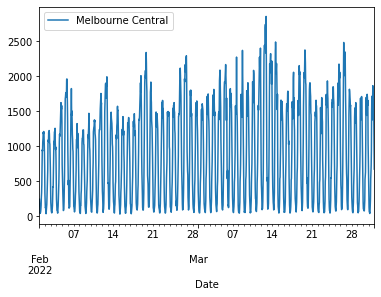

In [10]:
df.plot(kind = 'line')

Now we need to make sure that the dataset is *stationary*, namely that it has fixed mean and variance.

We can achieve this using the function `ADFTest` from the module `pmdarima`; if the resulting *pvalue* is lower than the selected acceptance level $\alpha$ (in our case $\alpha$ = 0.05), then we can conclude that the dataset is indeed stationary, otherwise, *differentiation* is needed to force stationarity:

In [11]:
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(df)

(0.01, False)

Now we split the dataset into *test* and *train* set, respectively the last 48 hours and all the previous remaining:

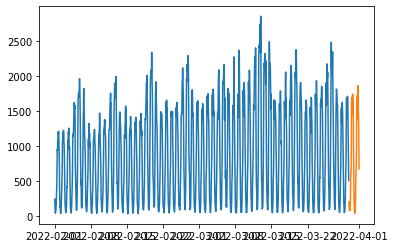

In [12]:
train = df[:-48]
test = df[-48:]
plt.plot(train)
plt.plot(test)

We have all we need to train the forecasting model; a seasonal <font color='green'>ARIMA</font> model was implemented and fit with the help of the `auto_arima` function:

In [14]:
arima_model = auto_arima(train, start_p=0, d=1, start_q=0,max_p=5, 
                         max_d=5, max_q=5, start_P=0,D=1, start_Q=0,
                         max_P=5, max_D=5,max_Q=5,m=12,seasonal=True,
                         error_action='warn',trace=True,supress_warnings=True,
                         stepwise=True, random_state=20,n_fits=50)

arima_model.summary()


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=20060.058, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=0.83 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.05 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.72 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=17368.485, Time=0.72 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=5.41 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=4.42 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=2.66 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=6.49 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=17363.991, Time=2.68 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=1.59 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=5.03 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=11.40 sec
 ARIMA(1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1368
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -8677.923
Date:                            Mon, 23 May 2022   AIC                          17363.847
Time:                                    20:43:09   BIC                          17384.693
Sample:                                         0   HQIC                         17371.652
                                           - 1368                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0760      0.021     -3.586      0.000      -0.117      -0.034
ar.S.L12      -0.9091      0.010    -87.477      0.000      -0.929      -0.889
ma.S.L12      -0.2141      0.026     -8.157      0.000      -0.266      -0.163
sigma2      2.104e+04    529.410     39.737      0.000       2e+04    2.21e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               588.32
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.85   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Now that the model is trained we can plot useful diagnostics about it:
* **Top left:** The residual errors seem to fluctuate around a mean of zero and have a (roughly) uniform variance
* **Top Right:** 
* **Bottom Left:**
* **Bottom Right:**

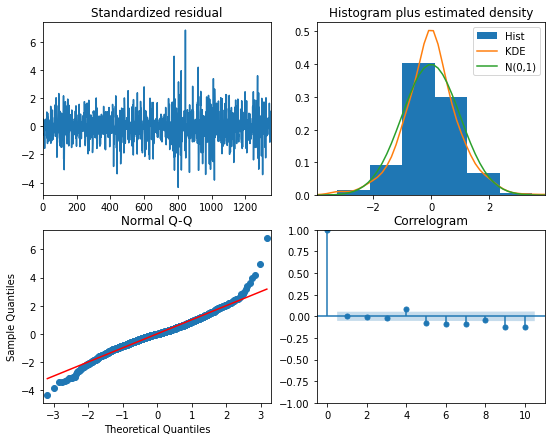

In [16]:
arima_model.plot_diagnostics(figsize=(9,7))
plt.show()

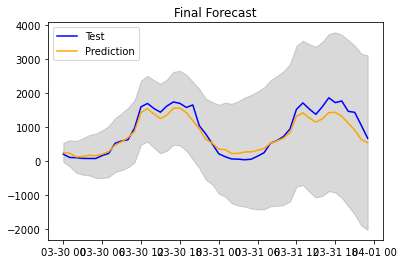

In [11]:
# Forecast
n_periods = len(test)
fc, confint = arima_model.predict(n_periods=n_periods, return_conf_int=True)


index_of_fc = test.index

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
# plt.plot(train)
plt.plot(test, color="blue", label='Test')
plt.plot(fc_series, color='orange', label='Prediction')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast")
plt.legend(loc ='upper left')
plt.show()

In [12]:
#evaluating our forecast computing the coefficient of determination r2 and the mean absolute percentage error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

print("Coefficient of determination for x is : " + str(r2_score(test, fc_series)))
print("MAPE for x is : " + str(mean_absolute_percentage_error(test, fc_series)))


Coefficient of determination for x is : 0.8879268624382622
MAPE for x is : 0.6535124789260266
